### Peforming checks for the resources available

In [1]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [2]:
!nvidia-smi

Mon Jan 11 08:03:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    11W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Installing huggingface transformers library

In [3]:
!pip install transformers

     |████████████████████████████████| 1.5MB 7.7MB/s 
     |████████████████████████████████| 890kB 28.0MB/s 
     |████████████████████████████████| 2.9MB 41.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=fd16d6d740d07e066ed6f9fdfd5740cc04a215a7149864433dcd78a3225971bb
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


## Importing necessary packages

In [4]:
import pandas as pd
import numpy as np 
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import time
import datetime
from sklearn.metrics import classification_report,confusion_matrix
import random
import time
import torch.nn as nn
from transformers import AutoModel , AutoModelForSequenceClassification, AutoConfig , AutoTokenizer , AdamW ,get_linear_schedule_with_warmup 
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
from matplotlib.ticker import MaxNLocator

## Setting some configuration values

In [5]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (16,12)

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

## Importing drive into the colaboratory

In [6]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


## Importing dataset directories

In [7]:
from os import getcwd , listdir 
from os.path import join
curr_dir = getcwd()
drive_dir = join(curr_dir , 'drive','MyDrive')
dataset_dir = join(drive_dir,'Codalab','Meme Classification Challenge','Dataset')
train_img_dir = join(dataset_dir,'training_img')
test_img_dir = join(dataset_dir,'test_img')
train_df = join(dataset_dir,'labels.csv')
test_df = join(dataset_dir,'test_captions.csv')

In [8]:
print(f" No. of images in training directory {len(listdir(train_img_dir))}")
print(f" No. of images in testing directory {len(listdir(test_img_dir))}")

 No. of images in training directory 2300
 No. of images in testing directory 667


In [9]:
import pandas as pd
df_path = join(dataset_dir,'labels.csv')
# Load the dataset into a pandas dataframe.
df = pd.read_csv(df_path)
df.sample(10)

,imagename,captions,labels
741,Not_troll_75.jpg,romba varuthapada vendiya vishiyam dhaan...,Not_troll
1917,troll_1854.jpg,YAARELLAM VELAIYADI IRUKKINGA...,troll
208,Not_troll_27.jpg,ippayellam nalladhuke kaalam illaa...,Not_troll
1546,troll_152.jpg,LOOSU KO MARIE PESADHA DHANASEKARA....!,troll
282,Not_troll_336.jpg,paarithu pala naatkal aairuchi.. nalla irukkir...,Not_troll
479,Not_troll_513.jpg,yenna boss ipidi aagiduchi..,Not_troll
1080,troll_1053.jpg,YAARU MUDHALLA VEETUKKU PORADHU YENUDU PAARPAM...,troll
1891,troll_1830.jpg,SURIYA VAMSAM THEVAYANI~ SARATHKUMAR'KU APPURA...,troll
111,Not_troll_182.jpg,idhellam oru page ah??,Not_troll
2085,troll_25.jpg,Cross salary net salary,troll


## Extracting `sentences` and `labels` from our training dataframe

In [10]:
sentences = df['captions'].values
labels = df['labels'].values

In [11]:
df['labels'].value_counts()

troll        1282
Not_troll    1018
Name: labels, dtype: int64

## LabelEncoding the target variable

In [12]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df.loc[:,'labels'] = le.fit_transform(df.loc[:,'labels'])

In [13]:
df['labels'].value_counts()

1    1282
0    1018
Name: labels, dtype: int64

## Splitting the dataset into `train` , `dev` set

In [14]:
from sklearn.model_selection import train_test_split
train_sentences, val_sentences , train_labels , val_labels = \
train_test_split(df['captions'],df['labels'],test_size = 0.2,random_state = 42,stratify = df['labels'])

In [15]:
train_sentences

1483    IVANA VIDA IVAN DHAN DA ENNA ROMBA TORCHEL PAN...
531           vunakkulam vukkarura yedathula katti vara..
1448    *ME : NETHU NIGHT UH, NEE CHICKEN AH ALLI ALLI...
415     mandaikku mela kondai irundha matum podhadhu.....
914     aahaa track namma pakkam thirumbudhe... appadi...
                              ...                        
1730    PANDRADHAYUM PANNITU MOONJIYA EPDI VACHURUKKAN...
12       Karupu vulaipaligalin vannam.. theriuma vunakku?
2226    pattu paduravan peru paadagan na !!   arrear v...
981           ni... nidhaan...   adhukku  sariya ippa....
1307    *BOYS : IPA ETHUKU IVLO MAKEUP POTRUKINGA..?? ...
Name: captions, Length: 1840, dtype: object

In [16]:
val_sentences

1232    ACTING LEVEL KARAN ANNA : KINDNESS(ANBU) , VIC...
566                                    aiyo! semma comedy
459     yennangada mudi idhu..??  naai nakkuna maadhir...
683               romba nalla irukku thambi vun karuthu..
1682    *DOCTOR : DEI NEE ENGINEER AH  *ENGINEER : AAM...
                              ...                        
524                       idhellam oru polappa..  thuu...
600             yedukku vambu nammalun adhaiye solluvom..
159                                 yenna oru villathanam
1840    #GROUP ADMIN: WHATSAPP GROUP ADMIN REACTION WH...
1752    NELLIN AADEIYAI KALEINDHAL AARISI..  ANDHA AVA...
Name: captions, Length: 460, dtype: object

In [18]:
train_labels.value_counts()

1    1026
0     814
Name: labels, dtype: int64

In [19]:
val_labels.value_counts()

1    256
0    204
Name: labels, dtype: int64

In [20]:
import numpy as np 
import random

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(train_sentences.shape[0]))

Number of training sentences: 1,840



## Saving Class Names

In [21]:
class_names = ['Not_troll','troll']

In [22]:
label_dict = {0:'Not_troll',1:'troll'}

## Handling class imbalance using `sklearn's comput_class_weight`

In [23]:
# from sklearn.utils.class_weight import compute_class_weight

# #compute the class weights
# class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)

# print(class_wts)

## Helper Functions

#### 1) Update Interval Function

In [24]:
def good_update_interval(total_iters, num_desired_updates):
    '''
    This function will try to pick an intelligent progress update interval 
    based on the magnitude of the total iterations.

    Parameters:
      `total_iters` - The number of iterations in the for-loop.
      `num_desired_updates` - How many times we want to see an update over the 
                              course of the for-loop.
    '''
    # Divide the total iterations by the desired number of updates. Most likely
    # this will be some ugly number.
    exact_interval = total_iters / num_desired_updates

    # The `round` function has the ability to round down a number to, e.g., the
    # nearest thousandth: round(exact_interval, -3)
    #
    # To determine the magnitude to round to, find the magnitude of the total,
    # and then go one magnitude below that.

    # Get the order of magnitude of the total.
    order_of_mag = len(str(total_iters)) - 1

    # Our update interval should be rounded to an order of magnitude smaller. 
    round_mag = order_of_mag - 1

    # Round down and cast to an int.
    update_interval = int(round(exact_interval, -round_mag))

    # Don't allow the interval to be zero!
    if update_interval == 0:
        update_interval = 1

    return update_interval

#### 2) Format time function

In [25]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


#### 3) Make Smart Batches function

In [26]:
def make_smart_batches(text_samples, labels, batch_size,tokenizer,max_input_length):
    '''
    This function combines all of the required steps to prepare batches.
    '''

    print('Creating Smart Batches from {:,} examples with batch size {:,}...\n'.format(len(text_samples), batch_size))

    # =========================
    #   Tokenize & Truncate
    # =========================

    full_input_ids = []

    # Tokenize all training examples
    print('Tokenizing {:,} samples...'.format(len(labels)))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(labels), num_desired_updates=10)

    # For each training example...
    for text in text_samples:
        
        # Report progress.
        if ((len(full_input_ids) % update_interval) == 0):
            print('  Tokenized {:,} samples.'.format(len(full_input_ids)))

        # Tokenize the sample.
        input_ids = tokenizer.encode(text=text,              # Text to encode.
                                    add_special_tokens=True, # Do add specials.
                                    max_length=max_input_length,      
                                    truncation=True,         # Do Truncate!
                                    padding=False)           # DO NOT pad.
                                    
        # Add the tokenized result to our list.
        full_input_ids.append(input_ids)
        
    print('DONE.')
    print('{:>10,} samples\n'.format(len(full_input_ids)))

    # =========================
    #      Select Batches
    # =========================    

    # Sort the two lists together by the length of the input sequence.
    samples = sorted(zip(full_input_ids, labels), key=lambda x: len(x[0]))

    print('{:>10,} samples after sorting\n'.format(len(samples)))

    import random

    # List of batches that we'll construct.
    batch_ordered_sentences = []
    batch_ordered_labels = []

    print('Creating batches of size {:}...'.format(batch_size))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(samples), num_desired_updates=10)
    
    # Loop over all of the input samples...    
    while len(samples) > 0:
        
        # Report progress.
        if ((len(batch_ordered_sentences) % update_interval) == 0 \
            and not len(batch_ordered_sentences) == 0):
            print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

        # `to_take` is our actual batch size. It will be `batch_size` until 
        # we get to the last batch, which may be smaller. 
        to_take = min(batch_size, len(samples))

        # Pick a random index in the list of remaining samples to start
        # our batch at.
        select = random.randint(0, len(samples) - to_take)

        # Select a contiguous batch of samples starting at `select`.
        #print("Selecting batch from {:} to {:}".format(select, select+to_take))
        batch = samples[select:(select + to_take)]

        #print("Batch length:", len(batch))

        # Each sample is a tuple--split them apart to create a separate list of 
        # sequences and a list of labels for this batch.
        batch_ordered_sentences.append([s[0] for s in batch])
        batch_ordered_labels.append([s[1] for s in batch])

        # Remove these samples from the list.
        del samples[select:select + to_take]

    print('\n  DONE - Selected {:,} batches.\n'.format(len(batch_ordered_sentences)))

    # =========================
    #        Add Padding
    # =========================    

    print('Padding out sequences within each batch...')

    py_inputs = []
    py_attn_masks = []
    py_labels = []

    # For each batch...
    for (batch_inputs, batch_labels) in zip(batch_ordered_sentences, batch_ordered_labels):

        # New version of the batch, this time with padded sequences and now with
        # attention masks defined.
        batch_padded_inputs = []
        batch_attn_masks = []
        
        # First, find the longest sample in the batch. 
        # Note that the sequences do currently include the special tokens!
        max_size = max([len(sen) for sen in batch_inputs])

        # For each input in this batch...
        for sen in batch_inputs:
            
            # How many pad tokens do we need to add?
            num_pads = max_size - len(sen)

            # Add `num_pads` padding tokens to the end of the sequence.
            padded_input = sen + [tokenizer.pad_token_id]*num_pads

            # Define the attention mask--it's just a `1` for every real token
            # and a `0` for every padding token.
            attn_mask = [1] * len(sen) + [0] * num_pads

            # Add the padded results to the batch.
            batch_padded_inputs.append(padded_input)
            batch_attn_masks.append(attn_mask)

        # Our batch has been padded, so we need to save this updated batch.
        # We also need the inputs to be PyTorch tensors, so we'll do that here.
        # Todo - Michael's code specified "dtype=torch.long"
        py_inputs.append(torch.tensor(batch_padded_inputs))
        py_attn_masks.append(torch.tensor(batch_attn_masks))
        py_labels.append(torch.tensor(batch_labels))
    
    print('  DONE.')

    # Return the smart-batched dataset!
    return (py_inputs, py_attn_masks, py_labels)


### 4) Make Smart Batches (On Test)

In [27]:
def make_smart_batches_on_test(text_samples, text_ids, batch_size,tokenizer,max_input_length):
    '''
    This function combines all of the required steps to prepare batches.
    '''

    print('Creating Smart Batches from {:,} examples with batch size {:,}...\n'.format(len(text_samples), batch_size))

    # =========================
    #   Tokenize & Truncate
    # =========================

    full_input_ids = []

    # Tokenize all training examples
    print('Tokenizing {:,} samples...'.format(len(text_samples)))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(text_samples), num_desired_updates=10)

    # For each training example...
    for text in text_samples:
        
        # Report progress.
        if ((len(full_input_ids) % update_interval) == 0):
            print('  Tokenized {:,} samples.'.format(len(full_input_ids)))

        # Tokenize the sample.
        input_ids = tokenizer.encode(text=text,              # Text to encode.
                                    add_special_tokens=True, # Do add specials.
                                    max_length=max_input_length,      
                                    truncation=True,         # Do Truncate!
                                    padding=False)           # DO NOT pad.
                                    
        # Add the tokenized result to our list.
        full_input_ids.append(input_ids)
        
    print('DONE.')
    print('{:>10,} samples\n'.format(len(full_input_ids)))

    # =========================
    #      Select Batches
    # =========================    

    # Sort the two lists together by the length of the input sequence.
    samples = sorted(zip(full_input_ids, text_ids), key=lambda x: len(x[0]))

    print('{:>10,} samples after sorting\n'.format(len(samples)))

    import random

    # List of batches that we'll construct.
    batch_ordered_sentences = []
    batch_ordered_ids = []

    print('Creating batches of size {:}...'.format(batch_size))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(samples), num_desired_updates=10)
    
    # Loop over all of the input samples...    
    while len(samples) > 0:
        
        # Report progress.
        if ((len(batch_ordered_sentences) % update_interval) == 0 \
            and not len(batch_ordered_sentences) == 0):
            print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

        # `to_take` is our actual batch size. It will be `batch_size` until 
        # we get to the last batch, which may be smaller. 
        to_take = min(batch_size, len(samples))

        # Pick a random index in the list of remaining samples to start
        # our batch at.
        select = random.randint(0, len(samples) - to_take)

        # Select a contiguous batch of samples starting at `select`.
        #print("Selecting batch from {:} to {:}".format(select, select+to_take))
        batch = samples[select:(select + to_take)]

        #print("Batch length:", len(batch))

        # Each sample is a tuple--split them apart to create a separate list of 
        # sequences and a list of labels for this batch.
        batch_ordered_sentences.append([s[0] for s in batch])
        batch_ordered_ids.append([s[1] for s in batch])

        # Remove these samples from the list.
        del samples[select:select + to_take]

    print('\n  DONE - Selected {:,} batches.\n'.format(len(batch_ordered_sentences)))

    # =========================
    #        Add Padding
    # =========================    

    print('Padding out sequences within each batch...')

    py_inputs = []
    py_attn_masks = []
    py_ids = []

    # For each batch...
    for (batch_inputs, batch_ids) in zip(batch_ordered_sentences, batch_ordered_ids):

        # New version of the batch, this time with padded sequences and now with
        # attention masks defined.
        batch_padded_inputs = []
        batch_attn_masks = []
        
        # First, find the longest sample in the batch. 
        # Note that the sequences do currently include the special tokens!
        max_size = max([len(sen) for sen in batch_inputs])

        # For each input in this batch...
        for sen in batch_inputs:
            
            # How many pad tokens do we need to add?
            num_pads = max_size - len(sen)

            # Add `num_pads` padding tokens to the end of the sequence.
            padded_input = sen + [tokenizer.pad_token_id]*num_pads

            # Define the attention mask--it's just a `1` for every real token
            # and a `0` for every padding token.
            attn_mask = [1] * len(sen) + [0] * num_pads

            # Add the padded results to the batch.
            batch_padded_inputs.append(padded_input)
            batch_attn_masks.append(attn_mask)

        # Our batch has been padded, so we need to save this updated batch.
        # We also need the inputs to be PyTorch tensors, so we'll do that here.
        # Todo - Michael's code specified "dtype=torch.long"
        py_inputs.append(torch.tensor(batch_padded_inputs))
        py_attn_masks.append(torch.tensor(batch_attn_masks))
        py_ids.append(torch.tensor(batch_ids))
    
    print('  DONE.')

    # Return the smart-batched dataset!
    return (py_inputs, py_attn_masks, py_ids)


### 5) Function for calculating accuracy per class

In [28]:
def accuracy_per_class(preds, labels , label_dict):
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict[label]}')
        print(f'Accuracy: {round(100*len(y_preds[y_preds==label])/len(y_true) , 2)}\n')

### 6) Function for plotting training history

In [29]:
def plot_training_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

  ax1.plot(history['train_loss'], label='train loss')
  ax1.plot(history['val_loss'], label='validation loss')

  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax1.set_ylim([-0.05, 1.05])
  ax1.legend()
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Epoch')

  ax2.plot(history['train_acc'], label='train accuracy')
  ax2.plot(history['val_acc'], label='validation accuracy')

  ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax2.set_ylim([-0.05, 1.05])
  ax2.legend()

  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')

  fig.suptitle('Training history')

### 7) Function to check accuracy

In [30]:
def check_accuracy(predictions,true_labels):
  # Combine the results across the batches.
  predictions = np.concatenate(predictions, axis=0)
  true_labels = np.concatenate(true_labels, axis=0)

  # Choose the label with the highest score as our prediction.
  preds = np.argmax(predictions, axis=1).flatten()

  # Calculate simple flat accuracy -- number correct over total number.
  accuracy = (preds == true_labels).mean()

  return accuracy

### 8) Function to evaluate model

In [31]:
def eval_model(model,py_inputs, py_attn_masks, py_labels):
# Prediction on test set
  t0 = time.time()

  print('Doing validation on {:,} sentences...'.format(len(py_labels)))

  # Put model in evaluation mode
  model.eval()

  # Tracking variables 
  predictions , true_labels = [], []

  # Choose an interval on which to print progress updates.
  update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

  # Measure elapsed time.
  t0 = time.time()
  total_val_loss = 0

  # Put model in evaluation mode
  model.eval()

  # For each batch of training data...
  for step in range(0, len(py_inputs)):

      # Progress update every 100 batches.
      if step % update_interval == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          elapsed = format_time(time.time() - t0)
          
          # Calculate the time remaining based on our progress.
          steps_per_sec = (time.time() - t0) / step
          remaining_sec = steps_per_sec * (len(py_inputs) - step)
          remaining = format_time(remaining_sec)

          # Report progress.
          print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

      # Copy the batch to the GPU.
      b_input_ids = py_inputs[step].to(device)
      b_input_mask = py_attn_masks[step].to(device)
      b_labels = py_labels[step].to(device)
    
      # Telling the model not to compute or store gradients, saving memory and 
      # speeding up prediction
      with torch.no_grad():
        output = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)


      logits = output.logits 
      loss = output.loss
      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()
    
      # Store predictions and true labels
      predictions.append(logits)
      true_labels.append(label_ids)

      total_val_loss += loss.item()
  
  val_accuracy = check_accuracy(predictions,true_labels)

  validation_time = format_time(time.time() - t0)
  
  # Calculate the average loss over all of the batches.
  avg_val_loss = total_val_loss / len(py_inputs)     
    

  # print('Accuracy: {:.3f}'.format(val_accuracy))
  return (avg_val_loss,val_accuracy,validation_time)


### 9) Function for making predictions on our test dataset

In [32]:
def get_predictions(py_inputs, py_attn_masks, py_labels):

  print('Predicting labels for {:,} test batches...'.format(len(py_labels)))

  # Put model in evaluation mode
  model.eval()

  # Tracking variables 
  predictions , true_labels = [], []

  # Choose an interval on which to print progress updates.
  update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

  # Measure elapsed time.
  t0 = time.time()

  # Put model in evaluation mode
  model.eval()

  # For each batch of training data...
  for step in range(0, len(py_inputs)):

      # Progress update every 100 batches.
      if step % update_interval == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          elapsed = format_time(time.time() - t0)
          
          # Calculate the time remaining based on our progress.
          steps_per_sec = (time.time() - t0) / step
          remaining_sec = steps_per_sec * (len(py_inputs) - step)
          remaining = format_time(remaining_sec)

          # Report progress.
          print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

      # Copy the batch to the GPU.
      b_input_ids = py_inputs[step].to(device)
      b_input_mask = py_attn_masks[step].to(device)
      b_labels = py_labels[step].to(device)
    
      # Telling the model not to compute or store gradients, saving memory and 
      # speeding up prediction
      with torch.no_grad():
          # Forward pass, calculate logit predictions
          outputs = model(b_input_ids, b_input_mask)

      logits = outputs.logits 

      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()
    
      # Store predictions and true labels
      predictions.append(logits)
      true_labels.append(label_ids)
      # Combine the results across the batches.
  predictions = np.concatenate(predictions, axis=0)
  true_labels = np.concatenate(true_labels, axis=0)

      # Choose the label with the highest score as our prediction.
  preds = np.argmax(predictions, axis=1).flatten()

  return (preds,true_labels)

### 10) Function for making predictions on test dataset(without labels)

In [33]:
def get_predictions_test(py_inputs, py_attn_masks,py_ids):

  print('Predicting labels for {:,} test batches...'.format(len(py_inputs)))

  # Put model in evaluation mode
  model.eval()

  # Tracking variables 
  predictions , true_labels ,ids = [], [] , []

  # Choose an interval on which to print progress updates.
  update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

  # Measure elapsed time.
  t0 = time.time()

  # Put model in evaluation mode
  model.eval()

  # For each batch of training data...
  for step in range(0, len(py_inputs)):

      # Progress update every 100 batches.
      if step % update_interval == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          elapsed = format_time(time.time() - t0)
          
          # Calculate the time remaining based on our progress.
          steps_per_sec = (time.time() - t0) / step
          remaining_sec = steps_per_sec * (len(py_inputs) - step)
          remaining = format_time(remaining_sec)

          # Report progress.
          print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

      # Copy the batch to the GPU.
      b_input_ids = py_inputs[step].to(device)
      b_input_mask = py_attn_masks[step].to(device)
      b_ids = py_ids[step].to(device)
    
      # Telling the model not to compute or store gradients, saving memory and 
      # speeding up prediction
      with torch.no_grad():
          # Forward pass, calculate logit predictions
          outputs = model(b_input_ids, b_input_mask)

      logits = outputs.logits 

      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      b_ids = b_ids.detach().cpu().numpy()
      # Store predictions
      predictions.append(logits)
      ids.append(b_ids)
      # Combine the results across the batches.
  predictions = np.concatenate(predictions, axis=0)
  ids = np.concatenate(ids,axis=0)
  # Choose the label with the highest score as our prediction.
  preds = np.argmax(predictions, axis=1).flatten()

  return ids,preds

### 11) Confusion Matrix Helper Function

In [34]:
def show_confusion_matrix(confusion_matrix, class_names):

  cm = confusion_matrix.copy()

  cell_counts = cm.flatten()

  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]

  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]

  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])

  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)

  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Sign')
  plt.xlabel('Predicted Sign');

## Loading tokenizer using AutoTokenizer from the transformers library

In [35]:
from transformers import AutoTokenizer

model_name = 'bert-base-multilingual-cased'
# Load the BERT tokenizer.
print(f'Loading {model_name} tokenizer...')
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False)

Loading bert-base-multilingual-cased tokenizer...


## Smart Batching of the training data

In [36]:
lengths = []
for text in train_sentences:
  lengths.append(len(text))       

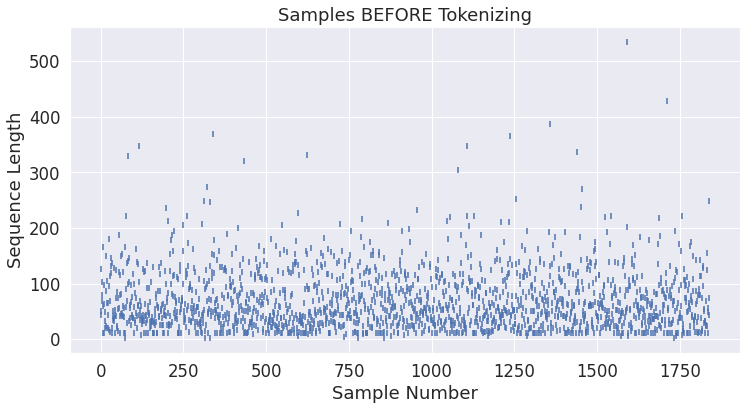

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.scatter(range(0, len(lengths)), lengths, marker="|")

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples BEFORE Tokenizing')

plt.show()

### Tokenizing the sequences

In [38]:
max_input_length = 400

In [39]:
full_input_ids = []
labels = []

# Tokenize all training examples
print('Tokenizing {:,} training samples...'.format(len(train_sentences)))

# Choose an interval on which to print progress updates.
update_interval = good_update_interval(total_iters=len(train_sentences), num_desired_updates=10)

# For each training example...
for text in train_sentences:
    
    # Report progress.
    if ((len(full_input_ids) % update_interval) == 0):
        print('  Tokenized {:,} samples.'.format(len(full_input_ids)))

    # Tokenize the sentence.
    input_ids = tokenizer.encode(text=text,           
                                 add_special_tokens=True, 
                                 max_length=max_input_length,  
                                 truncation=True,     
                                 padding=False)       
                                 
    # Add the tokenized result to our list.
    full_input_ids.append(input_ids)
    
print('DONE.')
print('{:>10,} samples'.format(len(full_input_ids)))

Tokenizing 1,840 training samples...
  Tokenized 0 samples.
  Tokenized 200 samples.
  Tokenized 400 samples.
  Tokenized 600 samples.
  Tokenized 800 samples.
  Tokenized 1,000 samples.
  Tokenized 1,200 samples.
  Tokenized 1,400 samples.
  Tokenized 1,600 samples.
  Tokenized 1,800 samples.
DONE.
     1,840 samples


In [40]:
# Get all of the lengths.
unsorted_lengths = [len(x) for x in full_input_ids]

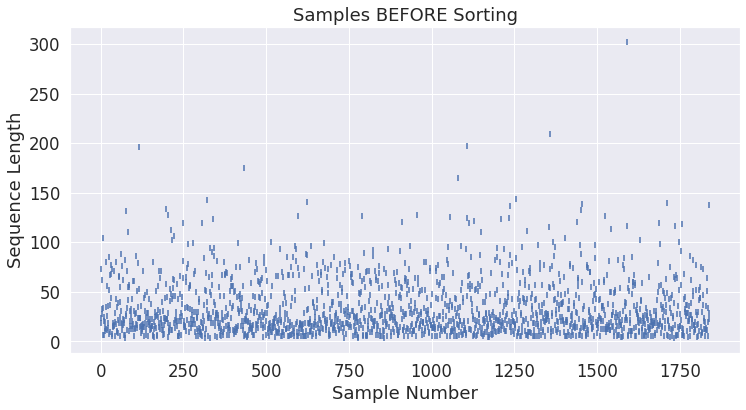

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.scatter(range(0, len(unsorted_lengths)), unsorted_lengths, marker="|")

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples BEFORE Sorting')

plt.show()

In [42]:
# Sort the two lists together by the length of the input sequence.
train_samples = sorted(zip(full_input_ids, train_labels), key=lambda x: len(x[0]))

In [43]:
train_samples[0:5]

[([101, 119, 102], 1),
 ([101, 119, 102], 1),
 ([101, 119, 102], 1),
 ([101, 10499, 102], 0),
 ([101, 119, 102], 1)]

In [44]:
print('Shortest sample:', len(train_samples[0][0]))
print('Longest sample:', len(train_samples[-1][0]))

Shortest sample: 3
Longest sample: 302


In [45]:
# Get the new list of lengths after sorting.
sorted_lengths = [len(s[0]) for s in train_samples]

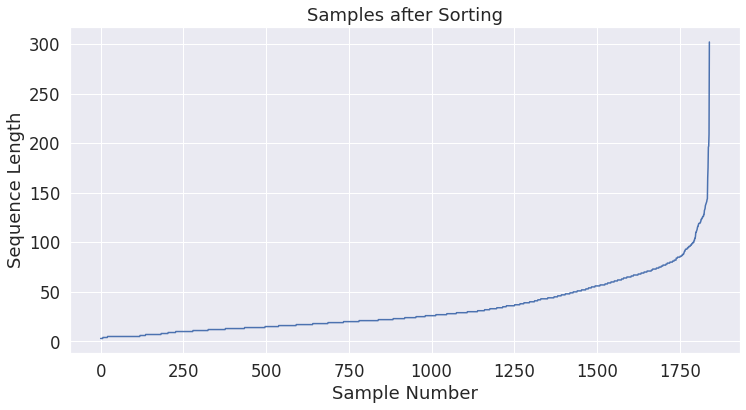

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(range(0, len(sorted_lengths)), sorted_lengths)

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples after Sorting')

plt.show()

### Random Batch Selections

In [47]:
train_samples[0]

([101, 119, 102], 1)

In [48]:
batch_size = 16

In [49]:
import random

# List of batches that we'll construct.
batch_ordered_sentences = []
batch_ordered_labels = []

print('Creating training batches of size {:}'.format(batch_size))

# Loop over all of the input samples...    
while len(train_samples) > 0:
    
    # Report progress.
    if ((len(batch_ordered_sentences) % 100) == 0):
        print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

    # `to_take` is our actual batch size. It will be `batch_size` until 
    # we get to the last batch, which may be smaller. 
    to_take = min(batch_size, len(train_samples))

    # Pick a random index in the list of remaining samples to start
    # our batch at.
    select = random.randint(0, len(train_samples) - to_take)

    # Select a contiguous batch of samples starting at `select`.
    batch = train_samples[select:(select + to_take)]

    # Each sample is a tuple--split them apart to create a separate list of 
    # sequences and a list of labels for this batch.
    batch_ordered_sentences.append([s[0] for s in batch])
    batch_ordered_labels.append([s[1] for s in batch])

    # Remove these samples from the list.
    del train_samples[select:select + to_take]

print('\n  DONE - {:,} batches.'.format(len(batch_ordered_sentences)))

Creating training batches of size 16
  Selected 0 batches.
  Selected 100 batches.

  DONE - 115 batches.


In [50]:
print(batch_ordered_sentences[0])

[[101, 49307, 11090, 49339, 11369, 14703, 139, 11403, 93202, 109821, 50655, 144, 73522, 66934, 47271, 10731, 11403, 80047, 39272, 11369, 139, 11403, 93202, 106, 106, 106, 160, 12396, 50655, 17443, 14703, 109544, 11517, 138, 74212, 85771, 119, 119, 119, 102], [101, 122, 32258, 148, 12022, 37911, 11273, 71020, 11537, 36742, 56586, 10738, 11281, 86607, 11259, 24124, 93520, 162, 52188, 12022, 98151, 118, 53197, 77968, 29990, 109166, 12022, 37817, 44376, 151, 12022, 23240, 11565, 24093, 157, 58132, 46876, 14703, 10738, 102], [101, 14753, 18453, 11023, 10115, 24623, 13723, 12449, 78560, 10174, 49123, 46689, 10401, 10737, 37879, 24960, 99778, 11067, 13015, 61471, 10147, 103218, 11023, 10115, 24623, 13723, 77586, 91251, 11542, 49123, 46689, 10401, 109995, 46296, 10213, 10514, 38263, 10514, 79644, 10138, 102], [101, 72894, 11153, 119, 119, 11089, 10113, 11023, 46689, 82708, 32510, 10113, 27689, 12806, 11023, 11083, 10147, 10135, 10219, 45567, 46296, 55085, 10113, 119, 119, 10592, 52523, 102295,

In [51]:
batch_ordered_labels[0]

[1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]

### Padding

In [52]:
import torch

py_inputs = []
py_attn_masks = []
py_labels = []

# For each batch...
for (batch_inputs, batch_labels) in zip(batch_ordered_sentences, batch_ordered_labels):

    # New version of the batch, this time with padded sequences and now with
    # attention masks defined.
    batch_padded_inputs = []
    batch_attn_masks = []
    
    # First, find the longest sample in the batch. 
    # Note that the sequences do currently include the special tokens!
    max_size = max([len(sen) for sen in batch_inputs])

    #print('Max size:', max_size)

    # For each input in this batch...
    for sen in batch_inputs:
        
        # How many pad tokens do we need to add?
        num_pads = max_size - len(sen)

        # Add `num_pads` padding tokens to the end of the sequence.
        padded_input = sen + [tokenizer.pad_token_id]*num_pads

        # Define the attention mask--it's just a `1` for every real token
        # and a `0` for every padding token.
        attn_mask = [1] * len(sen) + [0] * num_pads

        # Add the padded results to the batch.
        batch_padded_inputs.append(padded_input)
        batch_attn_masks.append(attn_mask)

    # Our batch has been padded, so we need to save this updated batch.
    # We also need the inputs to be PyTorch tensors, so we'll do that here.
    py_inputs.append(torch.tensor(batch_padded_inputs))
    py_attn_masks.append(torch.tensor(batch_attn_masks))
    py_labels.append(torch.tensor(batch_labels))


## Check the number of token reductions because of smart batching

In [53]:
# Get the new list of lengths after sorting.
import numpy as np
padded_lengths = []

# For each batch...
for batch in py_inputs:
    
    # For each sample...
    for s in batch:
    
        # Record its length.
        padded_lengths.append(len(s))

# Sum up the lengths to the get the total number of tokens after smart batching.
smart_token_count = np.sum(padded_lengths)

# To get the total number of tokens in the dataset using fixed padding, it's
# as simple as the number of samples times our `max_len` parameter (that we
# would pad everything to).
fixed_token_count = len(train_sentences) * max_input_length

# Calculate the percentage reduction.
prcnt_reduced = (fixed_token_count - smart_token_count) / float(fixed_token_count) 

print('Total tokens:')
print('   Fixed Padding: {:,}'.format(fixed_token_count))
print('  Smart Batching: {:,}  ({:.1%} less)'.format(smart_token_count, prcnt_reduced))


Total tokens:
   Fixed Padding: 736,000
  Smart Batching: 69,392  (90.6% less)


## Load the model from the transformers library using BertForSequenceClassifcation

In [54]:
from transformers import BertForSequenceClassification

# Load the pre-trained model for classification, passing in the `config` from
# above.

model = BertForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path=model_name,
    num_labels = 2, 
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)


print('\nModel type:', str(type(model)))


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch


Model type: <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'>


In [55]:
import torch
print('\nLoading model on the gpu...')
model.cuda()


Loading model on the gpu...


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

## Loading Optimizer

In [56]:
from transformers import AdamW

# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # This is the value Michael used.
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


## Loading Linear rate Scheduler

In [57]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. I chose to train for 1 simply because the training
# time is long. More epochs may improve the model's accuracy.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# Note that it's the number of *batches*, not *samples*!
total_steps = len(py_inputs) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## Training Loop

In [58]:
# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = {
    'epoch':[],
    'train_loss':[],
    'Training Time':[],
    'val_loss':[],
    'Validation Time':[],
    'train_acc':[],
    'val_acc':[]
}

# Update every `update_interval` batches.
update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    predictions = []
    true_labels = []
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    
    # At the start of each epoch (except for the first) we need to re-randomize
    # our training data.
    if epoch_i > 0:
        # Use our `make_smart_batches` function (from 6.1.) to re-shuffle the 
        # dataset into new batches.
        (py_inputs, py_attn_masks, py_labels) = make_smart_batches(train_sentences, train_labels, batch_size,tokenizer,max_input_length)
    
    print('Training on {:,} batches...'.format(len(py_inputs)))

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step in range(0, len(py_inputs)):

        # Progress update every, e.g., 100 batches.
        if step % update_interval == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Calculate the time remaining based on our progress.
            steps_per_sec = (time.time() - t0) / step
            remaining_sec = steps_per_sec * (len(py_inputs) - step)
            remaining = format_time(remaining_sec)

            # Report progress.
            print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

        # Copy the current training batch to the GPU using the `to` method.
        b_input_ids = py_inputs[step].to(device)
        b_input_mask = py_attn_masks[step].to(device)
        b_labels = py_labels[step].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass.
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The call returns the loss (because we provided labels) and the 
        # "logits"--the model outputs prior to activation.
        output = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        loss = output.loss 
        logits = output.logits

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
      
        # Store predictions and true labels
        predictions.append(logits)
        true_labels.append(label_ids)
        
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(py_inputs)     
       
    training_accuracy = check_accuracy(predictions,true_labels)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training Accuracy: {0:.2f}".format(training_accuracy))
    print("  Training epoch took: {:}".format(training_time))
        
    (py_inputs, py_attn_masks, py_labels) = make_smart_batches(val_sentences, val_labels, batch_size ,tokenizer,max_input_length)
    val_loss,val_accuracy,validation_time = eval_model(model,py_inputs, py_attn_masks, py_labels)  
    # Record all statistics from this epoch.

    print("")
    print("  Average validation loss: {0:.2f}".format(val_loss))
    print("  Validation Accuracy: {0:.2f}".format(val_accuracy))
    print("  Validation epoch took: {:}".format(validation_time))
    
    
    training_stats['epoch'].append(epoch_i + 1)
    training_stats['train_loss'].append(avg_train_loss)
    training_stats['Training Time'].append(training_time)
    training_stats['val_loss'].append(val_loss)
    training_stats['Validation Time'].append(validation_time)
    training_stats['train_acc'].append(training_accuracy)
    training_stats['val_acc'].append(val_accuracy)

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training on 115 batches...
  Batch      10  of      115.    Elapsed: 0:00:02.  Remaining: 0:00:17
  Batch      20  of      115.    Elapsed: 0:00:03.  Remaining: 0:00:15
  Batch      30  of      115.    Elapsed: 0:00:05.  Remaining: 0:00:14
  Batch      40  of      115.    Elapsed: 0:00:06.  Remaining: 0:00:12
  Batch      50  of      115.    Elapsed: 0:00:08.  Remaining: 0:00:10
  Batch      60  of      115.    Elapsed: 0:00:10.  Remaining: 0:00:09
  Batch      70  of      115.    Elapsed: 0:00:11.  Remaining: 0:00:07
  Batch      80  of      115.    Elapsed: 0:00:13.  Remaining: 0:00:06
  Batch      90  of      115.    Elapsed: 0:00:14.  Remaining: 0:00:04
  Batch     100  of      115.    Elapsed: 0:00:16.  Remaining: 0:00:02
  Batch     110  of      115.    Elapsed: 0:00:18.  Remaining: 0:00:01

  Average training loss: 0.29
  Training Accuracy: 0.88
  Training epoch took: 0:00:20
Creating Smart Batches from 460 examples with batch size 16...

Tokenizin

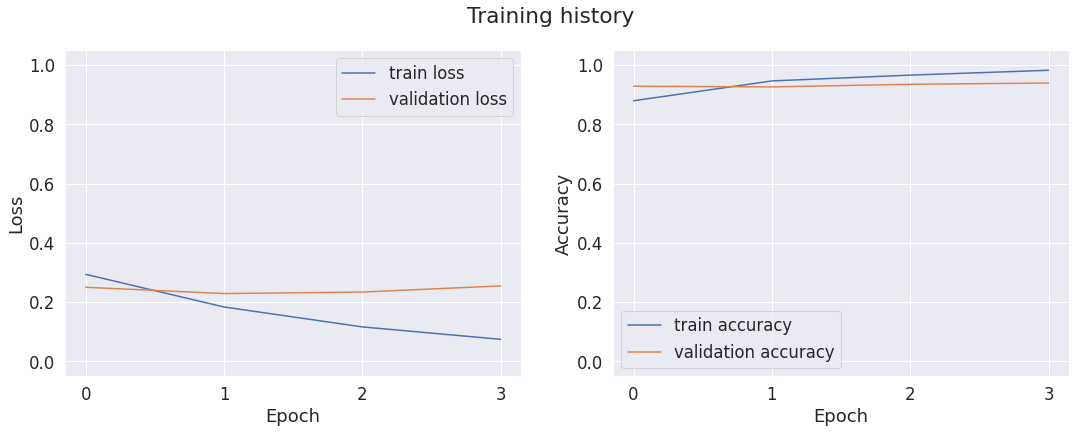

In [59]:
plot_training_history(training_stats)

## Evaluating Performance Over Training Set

In [60]:
(py_inputs, py_attn_masks, py_labels) = make_smart_batches(train_sentences, train_labels, batch_size ,tokenizer,max_input_length)

y_pred , y_true = get_predictions(py_inputs, py_attn_masks, py_labels)


Creating Smart Batches from 1,840 examples with batch size 16...

Tokenizing 1,840 samples...
  Tokenized 0 samples.
  Tokenized 200 samples.
  Tokenized 400 samples.
  Tokenized 600 samples.
  Tokenized 800 samples.
  Tokenized 1,000 samples.
  Tokenized 1,200 samples.
  Tokenized 1,400 samples.
  Tokenized 1,600 samples.
  Tokenized 1,800 samples.
DONE.
     1,840 samples

     1,840 samples after sorting

Creating batches of size 16...

  DONE - Selected 115 batches.

Padding out sequences within each batch...
  DONE.
Predicting labels for 115 test batches...
  Batch      10  of      115.    Elapsed: 0:00:00.  Remaining: 0:00:04
  Batch      20  of      115.    Elapsed: 0:00:01.  Remaining: 0:00:04
  Batch      30  of      115.    Elapsed: 0:00:01.  Remaining: 0:00:03
  Batch      40  of      115.    Elapsed: 0:00:02.  Remaining: 0:00:03
  Batch      50  of      115.    Elapsed: 0:00:02.  Remaining: 0:00:03
  Batch      60  of      115.    Elapsed: 0:00:02.  Remaining: 0:00:02
  Bat

In [61]:
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

   Not_troll       0.97      0.99      0.98       814
       troll       1.00      0.97      0.98      1026

    accuracy                           0.98      1840
   macro avg       0.98      0.98      0.98      1840
weighted avg       0.98      0.98      0.98      1840



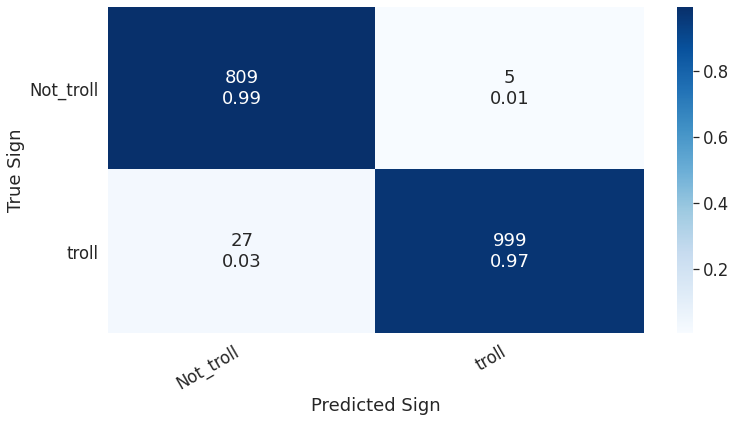

In [62]:
cm = confusion_matrix(y_true, y_pred)
show_confusion_matrix(cm, class_names)

## Evaluating Performance Over Validation Set

In [63]:
(py_inputs, py_attn_masks, py_labels) = make_smart_batches(val_sentences, val_labels, batch_size ,tokenizer,max_input_length)

y_pred , y_true = get_predictions(py_inputs, py_attn_masks, py_labels)

Creating Smart Batches from 460 examples with batch size 16...

Tokenizing 460 samples...
  Tokenized 0 samples.
  Tokenized 50 samples.
  Tokenized 100 samples.
  Tokenized 150 samples.
  Tokenized 200 samples.
  Tokenized 250 samples.
  Tokenized 300 samples.
  Tokenized 350 samples.
  Tokenized 400 samples.
  Tokenized 450 samples.
DONE.
       460 samples

       460 samples after sorting

Creating batches of size 16...

  DONE - Selected 29 batches.

Padding out sequences within each batch...
  DONE.
Predicting labels for 29 test batches...
  Batch       3  of       29.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch       6  of       29.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch       9  of       29.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch      12  of       29.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch      15  of       29.    Elapsed: 0:00:01.  Remaining: 0:00:01
  Batch      18  of       29.    Elapsed: 0:00:01.  Remaining: 0:00:00
  Batch      21  of   

In [64]:
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

   Not_troll       0.91      0.96      0.93       204
       troll       0.97      0.92      0.94       256

    accuracy                           0.94       460
   macro avg       0.94      0.94      0.94       460
weighted avg       0.94      0.94      0.94       460



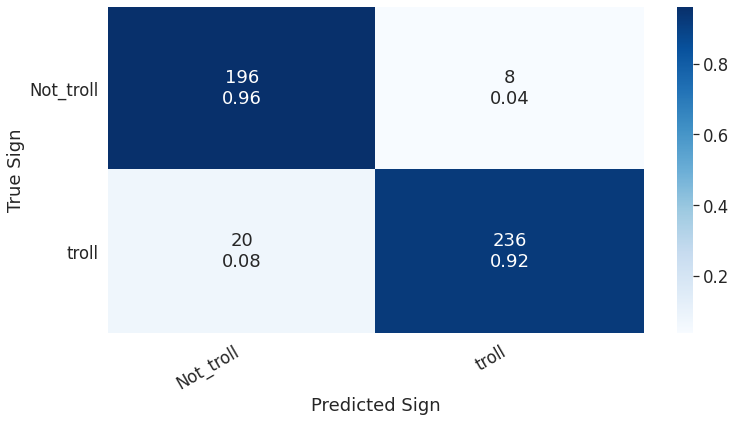

In [65]:
cm = confusion_matrix(y_true, y_pred)
show_confusion_matrix(cm, class_names)

## Saving the model

In [67]:
torch.save(
    model,
    "./drive/MyDrive/Codalab/Meme Classification Challenge/Models/BERTForSequenceClassification_Multi_cased_Tamil"
    )

## Loading the model

In [ ]:
model = torch.load(
    './drive/MyDrive/Meme Classification Challenge/Models/BERTForSequenceClassification_Multi_cased_Tamil',
                   map_location=device
    )

In [ ]:
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

## Making Predictions on Test Set

In [70]:
test_df = pd.read_csv(join(dataset_dir,'test_captions.csv'))

In [71]:
test_df

,Unnamed: 0,imagename,captions
0,0,test_img_0.jpg,sugarkaga nadandhava vida figuregaga nadandhav...
1,1,test_img_1.jpg,i have come for my stones stones thaane.....
2,2,test_img_2.jpg,"""special porotta"" nu pottuierukke spacial kum ..."
3,3,test_img_3.jpg,*we : amma .. cooker 3 whistle vanthuchu off p...
4,4,test_img_4.jpg,creating whatsapp group - 1st day vaanga ji.. ...
...,...,...,...
662,662,test_img_662.jpg,DURING SCHOOL DAYS ME & FRNDS: ANNA MAIL CHEC...
663,663,test_img_663.jpg,REMEMBER THIS KID THIS KID IS RIGHT NOW
664,664,test_img_664.jpg,*SINGLES: IVAN VERA ENGALA ROMBA TORCHER PANDR...
665,665,test_img_665.jpg,ENAIKI PUBG LA CHICKEN DINNER VANGURA PAYALUGA...


## Loading `test_sentences`

In [72]:
test_sentences = test_df['captions'].values 
test_ids = test_df.index.values

In [73]:
test_ids

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [74]:
test_sentences

array(['sugarkaga nadandhava vida figuregaga nadandhavan dhan adhigam',
       'i have come for my stones      stones thaane.. nalla cheap aana price la namma kalyan jewellers la kedaikkum',
       '"special porotta" nu pottuierukke spacial kum sadhavukkum yenna vidhiyasam..?     rendukkum oru naal dhan vidhiyasam..',
       '*we : amma .. cooker 3 whistle vanthuchu off panniten...',
       'creating whatsapp group - 1st day vaanga ji.. vaanga ji.. ellarayum add pannunga ji TEAM WORK PANROM...ENJOY PANROMM..   AFTER ONE WEEK ... ENNAYA..? IVLO AMAITHIYA IRUKEENGA? ETHACHU PESUNGAYA',
       '*FOODIE : YAARUM PAARKKAMAL ENNAI PAARKIREN ENNAI ARIYAMAL UNNAI PARKIREN',
       'MARGALI MAADHA EFFECT YENNA KULLURU',
       'YENNAMMA FEEL PANNI YELUTHI ERUKRANDA AVAN',
       'TAMIL SERIALS BE LIKE... INI AVARUKKU BADHIL..... IVAR',
       'Mama ponnu Expectation reality',
       'pondatti yennai thittum bodhu... eppavum unga amma pechai dhan kepingala.,,? en maganai thittum bodhu... amma pe

In [75]:
(py_inputs, py_attn_masks,py_ids) = make_smart_batches_on_test(test_sentences,test_ids, batch_size,tokenizer,max_input_length )

Creating Smart Batches from 667 examples with batch size 16...

Tokenizing 667 samples...
  Tokenized 0 samples.
  Tokenized 70 samples.
  Tokenized 140 samples.
  Tokenized 210 samples.
  Tokenized 280 samples.
  Tokenized 350 samples.
  Tokenized 420 samples.
  Tokenized 490 samples.
  Tokenized 560 samples.
  Tokenized 630 samples.
DONE.
       667 samples

       667 samples after sorting

Creating batches of size 16...

  DONE - Selected 42 batches.

Padding out sequences within each batch...
  DONE.


## Evaluating accuracy over test set

In [76]:
y_ids,y_preds  = get_predictions_test(py_inputs, py_attn_masks,py_ids)


Predicting labels for 42 test batches...
  Batch       4  of       42.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch       8  of       42.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch      12  of       42.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch      16  of       42.    Elapsed: 0:00:01.  Remaining: 0:00:01
  Batch      20  of       42.    Elapsed: 0:00:01.  Remaining: 0:00:01
  Batch      24  of       42.    Elapsed: 0:00:01.  Remaining: 0:00:01
  Batch      28  of       42.    Elapsed: 0:00:01.  Remaining: 0:00:01
  Batch      32  of       42.    Elapsed: 0:00:01.  Remaining: 0:00:00
  Batch      36  of       42.    Elapsed: 0:00:01.  Remaining: 0:00:00
  Batch      40  of       42.    Elapsed: 0:00:02.  Remaining: 0:00:00


In [77]:
print(y_preds)

[0 0 1 1 1 1 0 1 1 0 0 0 0 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 0 0 1 0 0 0 0 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 0 1 1 0 0 0 1 1 1 0 1 1 1 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1
 1 0 1 1 0 1 1 0 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1
 0 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 1 0 0
 1 0 1 1 0 0 0 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 0 0 0 1 1 1 1 1 0 1 0 1 0 1 0 1
 1 1 1 1 1 1 1 0 1 1 0 1 

In [78]:
print(y_ids)

[286 290 539  44 437 578 600  12  62 136 243 353 443 537 542 548 214 266
 314 363 387 445 496 555 640  45  52 269 295 311 324 343 641 663   7  27
 131 170 236 280 282 303 345 403 490  65  89 149 179 199 204 207 209 213
 218 224 232 251 284 613 630 647 660 594 283 421 440 453 509 529 543 558
 585 602 606   0   6  83  93 128 571 587 664  48 111 146 153 191 197 223
 246 356 388 461 582 126 428 450 561 575 603 608 617 623  47  82 165 169
 352 358 371 380  38 379 510 549 577 627 130 272 308 412 415 476 631 339
 427 634  56 121 137 183 212 216 259 268 305 328 331 355 411 419 504 565
 460 473 489 499 514 655  33 279 348 366 377 484 487 540   5  43 506 654
 382   4 229 653 180  40 625  24 564 573 390 633 502 281 463 492 560 563
 598  17 588 591  63  77 203 228 256 177 230 270 340 385 397 404 424 444
 485 488  69 301 335 456 495 127 156 245 624 172 517 520 574 581 614 187
 534 645  21 116 117 287 329 472 431 458 478 513   3  60  94 188 278 292
 297 321 394 433 553 636 306 566  41 546 554 242 31

In [79]:
le.inverse_transform(y_preds)

array(['Not_troll', 'Not_troll', 'troll', 'troll', 'troll', 'troll',
       'Not_troll', 'troll', 'troll', 'Not_troll', 'Not_troll',
       'Not_troll', 'Not_troll', 'troll', 'troll', 'troll', 'Not_troll',
       'Not_troll', 'troll', 'Not_troll', 'troll', 'troll', 'troll',
       'troll', 'troll', 'troll', 'troll', 'troll', 'Not_troll', 'troll',
       'troll', 'troll', 'troll', 'troll', 'troll', 'troll', 'troll',
       'troll', 'Not_troll', 'troll', 'troll', 'troll', 'troll', 'troll',
       'troll', 'troll', 'troll', 'Not_troll', 'Not_troll', 'troll',
       'Not_troll', 'Not_troll', 'Not_troll', 'Not_troll', 'troll',
       'Not_troll', 'Not_troll', 'Not_troll', 'Not_troll', 'troll',
       'troll', 'troll', 'troll', 'troll', 'troll', 'troll', 'troll',
       'troll', 'troll', 'troll', 'troll', 'Not_troll', 'troll',
       'Not_troll', 'Not_troll', 'troll', 'troll', 'troll', 'troll',
       'troll', 'troll', 'troll', 'troll', 'troll', 'troll', 'troll',
       'troll', 'Not_troll',

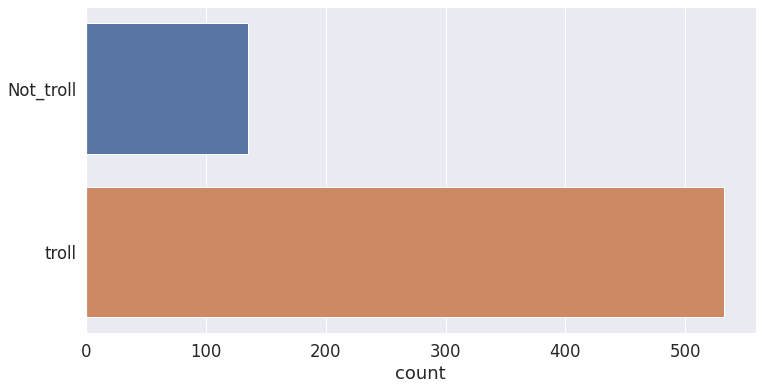

In [80]:
sns.countplot(y =le.inverse_transform(y_preds))

In [81]:
len(y_ids)

667

In [82]:
len(le.inverse_transform(y_preds))

667

## Creating Submission DataFrame

In [83]:
df_new = pd.DataFrame({
    'id':y_ids,
    'label':le.inverse_transform(y_preds)
})

In [84]:
test_df['id'] = test_df.index

In [85]:
df_new

,id,label
0,286,Not_troll
1,290,Not_troll
2,539,troll
3,44,troll
4,437,troll
...,...,...
662,190,troll
663,253,troll
664,294,Not_troll
665,300,troll


In [86]:
test_df

,Unnamed: 0,imagename,captions,id
0,0,test_img_0.jpg,sugarkaga nadandhava vida figuregaga nadandhav...,0
1,1,test_img_1.jpg,i have come for my stones stones thaane.....,1
2,2,test_img_2.jpg,"""special porotta"" nu pottuierukke spacial kum ...",2
3,3,test_img_3.jpg,*we : amma .. cooker 3 whistle vanthuchu off p...,3
4,4,test_img_4.jpg,creating whatsapp group - 1st day vaanga ji.. ...,4
...,...,...,...,...
662,662,test_img_662.jpg,DURING SCHOOL DAYS ME & FRNDS: ANNA MAIL CHEC...,662
663,663,test_img_663.jpg,REMEMBER THIS KID THIS KID IS RIGHT NOW,663
664,664,test_img_664.jpg,*SINGLES: IVAN VERA ENGALA ROMBA TORCHER PANDR...,664
665,665,test_img_665.jpg,ENAIKI PUBG LA CHICKEN DINNER VANGURA PAYALUGA...,665


In [87]:
df_f = pd.merge(test_df,df_new,on = 'id')
df_f

,Unnamed: 0,imagename,captions,id,label
0,0,test_img_0.jpg,sugarkaga nadandhava vida figuregaga nadandhav...,0,troll
1,1,test_img_1.jpg,i have come for my stones stones thaane.....,1,troll
2,2,test_img_2.jpg,"""special porotta"" nu pottuierukke spacial kum ...",2,Not_troll
3,3,test_img_3.jpg,*we : amma .. cooker 3 whistle vanthuchu off p...,3,troll
4,4,test_img_4.jpg,creating whatsapp group - 1st day vaanga ji.. ...,4,troll
...,...,...,...,...,...
662,662,test_img_662.jpg,DURING SCHOOL DAYS ME & FRNDS: ANNA MAIL CHEC...,662,troll
663,663,test_img_663.jpg,REMEMBER THIS KID THIS KID IS RIGHT NOW,663,troll
664,664,test_img_664.jpg,*SINGLES: IVAN VERA ENGALA ROMBA TORCHER PANDR...,664,troll
665,665,test_img_665.jpg,ENAIKI PUBG LA CHICKEN DINNER VANGURA PAYALUGA...,665,troll


In [88]:
df_f = df_f[['imagename','label']]
df_f

,imagename,label
0,test_img_0.jpg,troll
1,test_img_1.jpg,troll
2,test_img_2.jpg,Not_troll
3,test_img_3.jpg,troll
4,test_img_4.jpg,troll
...,...,...
662,test_img_662.jpg,troll
663,test_img_663.jpg,troll
664,test_img_664.jpg,troll
665,test_img_665.jpg,troll


## Saving Submission DataFrame

In [89]:
path = './drive/MyDrive/Codalab/Meme Classification Challenge/SubmissionFiles'

In [90]:
df_f.to_csv(join(path,'bert_multilingual_base_cased_tamil_memes.csv'),index=False)